## Notebook to research diabetes onset 


e) Matched Controls Diabetes Onset Curve(Blue 3)

   1. Get all the canary patients who have their CC_DIABETES flag equals 0
   on their registered date.
   
       1. Pick a matching algorithm
   2. Create the macthed population
       2. For each canary patient let their registration month be i
       2. Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       2. Set the index date for these pmpm controls patients to be month i.
       2. This forms a matched set of roughly 30 times the number of canary patients and each control has an index date.
   
   3. Compute Onset of Diabetes for month i: 
       3. Get all the matched controls with index date prior to month i.
       3. For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from e.3 that had
        the flag CC_DIABETES = 1 at Month (i) and CC_DIABETES = 0 at Month (i-1) (Note these patients must be in pmpm on both months).
       3. S is the total number of matched controls included in the pmpm both in month i and month i-1 
       3. For Month i we define the diabetes onset rate(DOR) as:
             DOR =  DO/S*1000

       3. Suggestion: Remove from  S the subjects that  have the flag CC_DIABETES = 1 at month i-1

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
import sys
sys.path.append('..')
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm Canary data

In [3]:
%%time
canary_p = '../../../data/CANARY/CANARY/CANARY202104'
pmpm_p = '../../../temp/PMPM.p'

canary = pd.read_pickle(canary_p)
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.04 s, sys: 3.52 s, total: 8.56 s
Wall time: 8.58 s


### Process Canary, 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated

In [4]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 5.31 s, sys: 1.65 s, total: 6.96 s
Wall time: 6.96 s


### Keep Canary Patients from their date of registeration and onwards which did not have CC_DIABETES flag on, on their date of registration

In [5]:
%%time
treated2 = in_canary(treated.copy(), canary2)
treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 3.49 s, sys: 10.6 ms, total: 3.5 s
Wall time: 3.49 s


### For each patient in the treated group in its registartion month find a population of matched controls in the same month by using 

In [6]:
%%time
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT']

propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 20}
matched, matched_data = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)

Mathcing Function: propensity_func
Propensity Score Matching...fitting model


/home/gmavroud/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Creating Matched Set...


1360it [39:19,  1.73s/it]


CPU times: user 34min 6s, sys: 14min 2s, total: 48min 8s
Wall time: 41min 49s


In [7]:
random_matching_func_args = {'neighbors_per_treated': 100}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


### Run the Diabetes onset Function

In [8]:
%%time
con_onset = diabet_onset(matched_data.copy(), 'Diabetes_Con')
treated_onset = diabet_onset(treated2.copy(), 'Diabetes_Tr')
pmpm2 = filter_first_month_diabetes(pmpm.copy())
pmpm_onset = diabet_onset(pmpm2, 'Diabetes_PM')

CPU times: user 3min 52s, sys: 9.86 s, total: 4min 2s
Wall time: 4min


In [9]:
random_onset = diabet_onset(random_controls.copy(), 'Diabetes_Rnd')

In [10]:
con_onset2 = con_onset.rename(columns = {'Sample': 'Sample_Con', 'Per_1000':'Per_1000_Con'})
treated_onset2 = treated_onset.rename(columns = {'Sample': 'Sample_Tr', 'Per_1000':'Per_1000_Tr'})
pmpm_onset2 = pmpm_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})

In [11]:
random_onset2 = random_onset.rename(columns = {'Sample': 'Sample_PM', 'Per_1000':'Per_1000_PM'})
joint = pd.concat((con_onset2, treated_onset2, pmpm_onset2, random_onset2), axis = 1)

### Diabetes Onset Per Month

1. **_Con : For Matched Controls Population**
2.  **_Tr : For Canary Treated Population**
3. **_PM : For the whole PMPM Population**
4. **_Rnd: For a Random Matching**

In [12]:
joint.describe().loc[['mean', 'std']]

Sample_Con  Diabetes_Con  Per_1000_Con   Sample_Tr  Diabetes_Tr  Per_1000_Tr      Sample_PM  Diabetes_PM  Per_1000_PM     Sample_PM  Diabetes_Rnd  Per_1000_PM
mean  6336.351351     11.081081      1.615751  378.621622     0.648649     1.262788  141550.543478   275.369565     1.950861  27179.081081     47.324324     2.166528
std   6282.329333     12.111469      1.275399  387.260489     1.059775     2.631552   13456.572672    46.930852     0.301403  25587.106793     45.246273     2.330431

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-dark')

In [14]:
joint2 = pd.concat((con_onset, treated_onset, pmpm_onset, random_onset), axis = 1)
jointcon = joint2.Per_1000.iloc[1:, 0].reset_index()
jointTr = joint2.Per_1000.iloc[1:, 1].reset_index()
jointpmpm = joint2.Per_1000.iloc[1:, 2].reset_index()
jointrandom = joint2.Per_1000.iloc[1:, 3].reset_index()


**Plot Top Left**: $f(x)$ = Onset Per 1000 per month </br>
**Plot Top Right and Bottom Left**: $F(x) = \int_0^x f(y)dy$ Cumulative sum of the rates

No handles with labels found to put in legend.


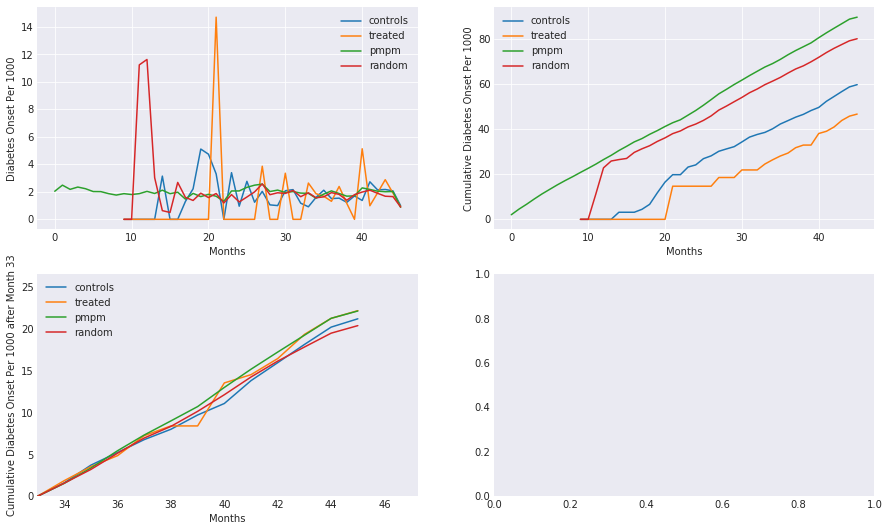

In [15]:
from diabetes_onset_plotter import plot_onset, plot_onset2
names = ['controls', 'treated', 'pmpm', 'random']
f, ax = plot_onset2(jointcon, jointTr, jointpmpm, jointrandom, names = names)
plt.show()

In [16]:
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

tr_desc = treated2[columns_to_match].describe().loc[['mean']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc = tr_desc.T

con_desc = matched_data[columns_to_match].describe().loc[['mean']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc = con_desc.T

pmpm_desc = pmpm2[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc = random_controls[columns_to_match].describe().loc[['mean']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

alli = pd.concat((tr_desc, con_desc, pmpm_desc, random_desc), axis = 1, keys = ['TREATED', 'MATCHED', 'PMPM', 'RANDOM'] )

In [17]:
alli

TREATED     MATCHED        PMPM      RANDOM
                       mean        mean        mean        mean
AGE_AT_MIDMONTH   49.955875   50.002041   48.799608   49.791769
ALLOW_AMT        728.824987  687.709507  737.608200  707.127947
MBR_GNDR           0.178636    0.187006    0.420833    0.421550
CC_TOBACCO         0.066511    0.106073    0.098876    0.103648
CC_PRESSURE        0.001747    0.006302    0.007079    0.006979
CC_OBESITY         0.494436    0.352120    0.227449    0.269923
CC_HYPERTENSION    0.315153    0.345951    0.282948    0.289000
CC_HYPOTHYROID     0.092391    0.101510    0.069469    0.074301
CC_DX_CNT          2.732272    2.847002    2.520817    2.674295

In [18]:
random_controls.shape